# Import Package and Data

The process begins with importing essential libraries for data handling and visualization. The dataset DASH_A1.csv, is then loaded. 



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('DASH_A1.csv')

# Data Cleaning
The approach follows the cleaning rules in a clear way. The "Date" column is set as the index to facilitate time series analyses and ensure chronological order. Duplicate rows are removed to maintain data integrity, and the dataset is sorted by date to preserve correct temporal order. A decision was made to drop all duplicate rows without individual inspection, based on the assumption that they were not meaningful. Missing values in the "Open", "Close", "High", "Low", and "Volume" columns are filled using the methods described in the rules: for example, we used the previous day’s close for missing open prices, and the monthly average for missing highs and lows. The code uses pandas functions to apply these steps to the whole dataset at once, which makes the process efficient and easy to read. 

In [13]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.set_index('Date').sort_index()

# Counting and removing duplicates
df.duplicated().sum()
df.drop_duplicates(inplace=True)

# Fill missing Open with previous day's Close
df["Open"] = df["Open"].fillna(df["Close"].shift(1))

# Fill missing Close using forward fill
df["Close"] = df["Close"].ffill()

# Fill High and Low using monthly mean (resample by month end)
monthly_high = df.resample("M").High.transform("mean")
monthly_low = df.resample("M").Low.transform("mean")
df["High"] = df["High"].fillna(monthly_high)
df["Low"] = df["Low"].fillna(monthly_low)

# Fill Volume: 0 if Close == Open, else with median
median_vol = df["Volume"].median()
vol_na = df["Volume"].isna()
mask_zero = vol_na & (df["Close"] == df["Open"])
mask_nonzero = vol_na & (df["Close"] != df["Open"])
df.loc[mask_zero, "Volume"] = 0
df.loc[mask_nonzero, "Volume"] = median_vol

# Final check for remaining missing values
df.isnull().sum()

/tmp/ipykernel_29391/263595080.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_high = df.resample("M").High.transform("mean")
/tmp/ipykernel_29391/263595080.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_low = df.resample("M").Low.transform("mean")


Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

# Feature Engineering

This process adds new features to the cleaned dataset to help with financial analysis. Simple daily returns and log returns were calculated to measure day-to-day changes in closing prices. A 20-day momentum and a 20-day simple moving average were added to show short-term trends. Rolling volatility over 20 days was used to measure risk.

The day of the week was included for each date to spot weekday patterns. Price surges were marked when daily returns were more than 4 standard deviations above the average. Volume spikes were identified using a 6 standard deviation threshold. Finally, Bollinger Bands were added using the 20-day moving average and standard deviation to show possible overbought or oversold conditions.



In [14]:
# Simple Daily Returns
df["Simple_Return"] = df["Close"].pct_change()

# Logarithmic Returns
df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))

# 20-Day Momentum
df["20D_Momentum"] = df["Close"] - df["Close"].shift(20)

# 20-Day Simple Moving Average
df["20D_SMA"] = df["Close"].rolling(window=20).mean()

# 20-Day Rolling Volatility (Standard Deviation of Simple Returns)
df["20D_Volatility"] = df["Simple_Return"].rolling(window=20).std()

# Day of the Week
df["Weekday"] = df.index.day_name()

# Price Surge Identification (Daily return > mean + 4*std)
mean_return = df["Simple_Return"].mean()
std_return = df["Simple_Return"].std()
df["Price_Surge"] = df["Simple_Return"] > (mean_return + 4 * std_return)

# Volume Spike Identification (Volume > mean + 6*std)
mean_volume = df["Volume"].mean()
std_volume = df["Volume"].std()
df["Volume_Spike"] = df["Volume"] > (mean_volume + 6 * std_volume)

# Bollinger Bands
df["20D_STD"] = df["Close"].rolling(window=20).std()
df["Upper_BB"] = df["20D_SMA"] + 2 * df["20D_STD"]
df["Lower_BB"] = df["20D_SMA"] - 2 * df["20D_STD"]

df.to_csv('DASH_A1_featured.csv', index=True)
df.head()


,Close,High,Low,Open,Volume,Simple_Return,Log_Return,20D_Momentum,20D_SMA,20D_Volatility,Weekday,Price_Surge,Volume_Spike,20D_STD,Upper_BB,Lower_BB
Date,,,,,,,,,,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700.0,NaN,NaN,NaN,NaN,NaN,Wednesday,False,False,NaN,NaN,NaN
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506800.0,-0.018521,-0.018695,NaN,NaN,NaN,Thursday,False,False,NaN,NaN,NaN
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600.0,-0.059140,-0.060961,NaN,NaN,NaN,Friday,False,False,NaN,NaN,NaN
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600.0,-0.085714,-0.089612,NaN,NaN,NaN,Monday,False,False,NaN,NaN,NaN
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000.0,-0.006938,-0.006962,NaN,NaN,NaN,Tuesday,False,False,NaN,NaN,NaN


# Identifying key dates
This process focuses on identifying important yearly statistics from the financial dataset. First, simple returns and 20-day volatility are calculated to measure daily performance and risk. The year is then extracted from each date to group the data by calendar year.

For each year, key dates and values are identified, such as the highest volatility day, the biggest price surge and drop, the highest volume, the highest and lowest prices, and the opening and closing prices of the year. These are collected using a custom function and saved into a summary table.


In [15]:
# Extract Year from Date for grouping
df["Year"] = df.index.year

# Define function to extract key dates and values
def extract_key_dates(group):
    def safe_idxmax(series):
        return series.idxmax() if series.notna().any() else np.nan
    def safe_idxmin(series):
        return series.idxmin() if series.notna().any() else np.nan

    return pd.Series({
        "Highest Volatility Date": safe_idxmax(group["20D_Volatility"]),
        "Highest Volatility Value": group["20D_Volatility"].max(),
        "Largest Price Surge Date": safe_idxmax(group["Simple_Return"]),
        "Largest Price Surge Value": group["Simple_Return"].max(),
        "Largest Price Drop Date": safe_idxmin(group["Simple_Return"]),
        "Largest Price Drop Value": group["Simple_Return"].min(),
        "Highest Volume Date": safe_idxmax(group["Volume"]),
        "Highest Volume Value": group["Volume"].max(),
        "Highest High Date": safe_idxmax(group["High"]),
        "Highest High Value": group["High"].max(),
        "Lowest Low Date": safe_idxmin(group["Low"]),
        "Lowest Low Value": group["Low"].min(),
        "Annual Open Price": group["Open"].iloc[0],
        "Annual Close Price": group["Close"].iloc[-1],
    })

# Apply the function by year
key_dates_by_year = df.groupby("Year").apply(extract_key_dates)

# Display result
all_years = pd.Index(df["Year"].unique(), name="Year")
key_dates_by_year = key_dates_by_year.reindex(all_years)

print(key_dates_by_year)

# Save the key dates to a CSV file
key_dates_by_year.to_csv('DASH_A1_key_dates.csv')


     Highest Volatility Date  Highest Volatility Value  \
Year                                                     
2020                     NaT                       NaN   
2021              2021-05-20                  0.067393   
2022              2022-06-01                  0.080994   
2023              2023-11-06                  0.047470   
2024              2024-02-27                  0.033547   
2025              2025-04-10                  0.048324   

     Largest Price Surge Date  Largest Price Surge Value  \
Year                                                       
2020               2020-12-18                   0.078724   
2021               2021-05-14                   0.221491   
2022               2022-03-16                   0.134512   
2023               2023-11-02                   0.156653   
2024               2024-08-02                   0.083457   
2025               2025-04-09                   0.137738   

     Largest Price Drop Date  Largest Price Drop Value

/tmp/ipykernel_29391/3897405925.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  key_dates_by_year = df.groupby("Year").apply(extract_key_dates)


# Data Visualisation
This section uses the cleaned dataset to create visualisations that help understand key financial patterns. Before plotting, important features such as daily returns, volatility, moving averages, and Bollinger Bands are calculated.

Three main plots are created:

- The first shows the close price with the 20-day average and Bollinger Bands to highlight price trends and potential trading signals.

- The second shows daily trading volume to identify changes in activity.

- The third shows 20-day volatility to track risk over time.

- Additional plots include a histogram of log returns to observe return distribution and a scatter plot comparing trading volume and daily returns, which may reveal relationships between activity and price movement.

These visualisations support deeper insights into the behaviour of the stock over time.

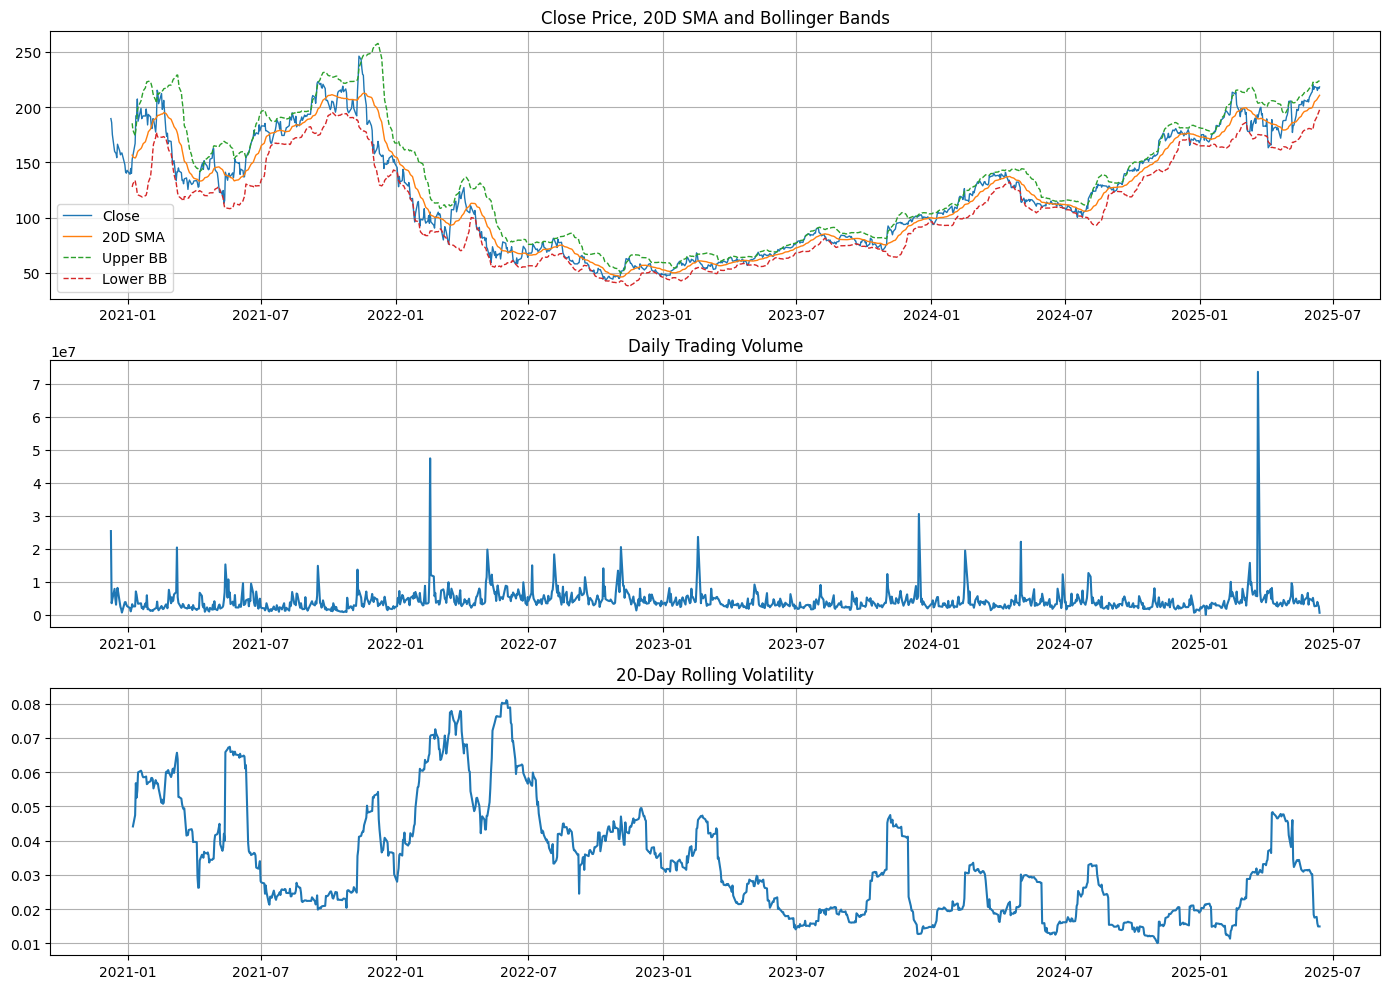

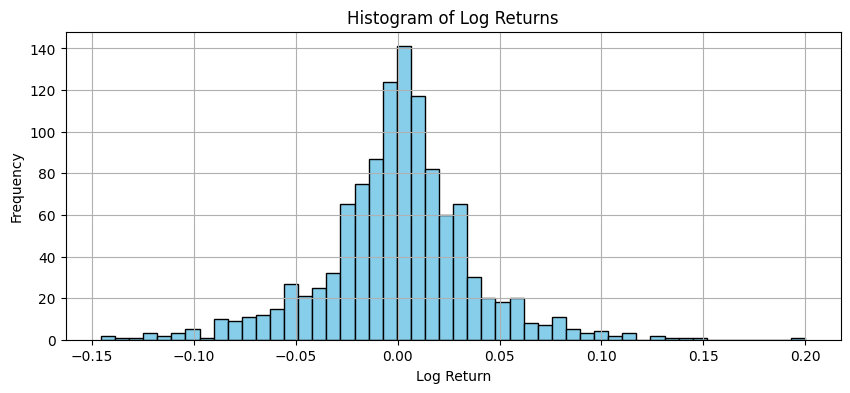

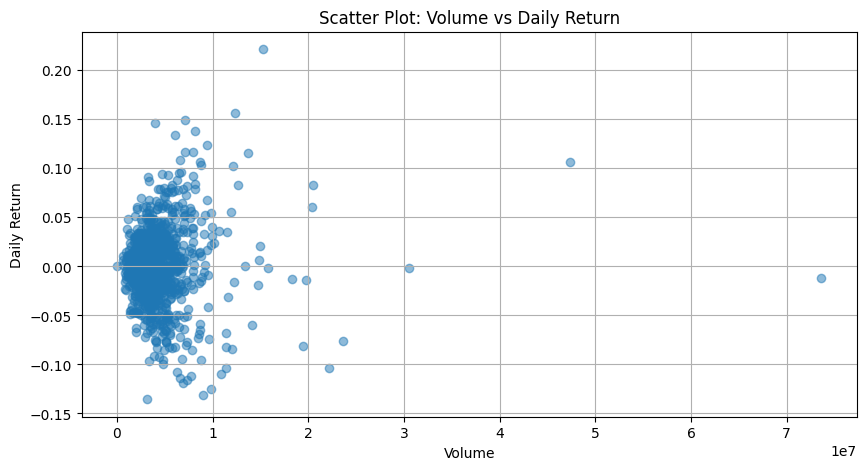

In [16]:
# Plotting the data
plt.figure(figsize=(14, 10))

# Close Price, 20D SMA and Bollinger Bands
ax1 = plt.subplot(3, 1, 1)
ax1.plot(df.index, df['Close'], label='Close', linewidth=1)
ax1.plot(df.index, df['20D_SMA'], label='20D SMA', linewidth=1)
ax1.plot(df.index, df['Upper_BB'], label='Upper BB', linestyle='--', linewidth=1)
ax1.plot(df.index, df['Lower_BB'], label='Lower BB', linestyle='--', linewidth=1)
ax1.set_title('Close Price, 20D SMA and Bollinger Bands')
ax1.legend()
ax1.grid(True)

# Volume
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(df.index, df['Volume'], color='tab:blue')
ax2.set_title('Daily Trading Volume')
ax2.grid(True)

# Volatility
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(df.index, df['20D_Volatility'], color='tab:blue')
ax3.set_title('20-Day Rolling Volatility')
ax3.grid(True)

plt.tight_layout()
plt.show()

# Log Returns Histogram
plt.figure(figsize=(10, 4))
plt.hist(df['Log_Return'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Scatter plot Volume vs Simple Return
plt.figure(figsize=(10, 5))
plt.scatter(df['Volume'], df['Simple_Return'], alpha=0.5)
plt.title('Scatter Plot: Volume vs Daily Return')
plt.xlabel('Volume')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()

# Recommendation

## Member 1:
The firm could incrementally increase its stake in DoorDash, as a moderately positive movement is likely. The approach gives leeway to monitor how the market responds to recent developments. The Bollinger Bands indicate a bullish trend post-2022. Previously, when the graph was bearish, it was due to pandemic volatility as well as DoorDash going public (Doordash, 2020). Currently, volatility might be attributed to Doordash’s recent acquisition of Deliveroo (Aratani, 2025). Given this move towards expansion, there is likely to be an increase in stock value following market adjustment.  

 The investment is also relatively low risk. Also, from the scatter plot, daily returns are generally consistent with small ups and downs. There have been minor anomalies, but these happen rarely and are spread apart in time. A recent spike makes another unlikely in the short term. 


Aratani, L. (2025) US food delivery app DoorDash offers to buy UK rival Deliveroo for $3.6bn. 25 April 2025. the Guardian.  https://www.theguardian.com/business/2025/apr/26/doordash-buy-deliveroo. 

DoorDash (2020) DoorDash - DoorDash Announces Pricing of Initial Public Offering. 8 December 2020. ir.doordash.com. https://ir.doordash.com/news/news-details/2020/DoorDash-Announces-Pricing-of-Initial-Public-Offering/default.aspx. 



## Member 2:

An overall look at DASH’s price, trading volume and volatility shows a clear rebound followed by steady growth. The stock dropped sharply in 2022 and reached a historical low, but since early 2023 it has been recovering well, rising steadily and breaking through several past resistance levels. On key trading days, volume also increased noticeably, showing strong market response and support for price movements. Recently, price swings have become more stable compared to the sharp fluctuations in 2022. The price range has stayed within normal limits, which suggests a more stable and healthy upward trend. 

Based on these signs, it could be a good time to consider adding to the DASH position. The stock has shown strong momentum, more than doubling in value since 2023. This may reflect both improved company performance and growing investor confidence. Still, the stock has a history of large single-day drops, and its return chart shows clear signs of high volatility. To reduce risk, a gradual buying approach is suggested, along with clear stop-loss points to avoid large losses during unexpected pullbacks. 

## Member 3:

The firm can gradually increase its stake in DoorDash due to the overall upward trend since 2023-01. After reaching a high of $257.25 in 2021 and experiencing a sharp decline to approximately $48 in 2022, DoorDash has shown signs of a gradual recovery. This is supported by increased trading volumes, narrowing Bollinger Bands, and alignment with the 20-day simple moving average, indicating better price support and reduced noise. The 20-day rolling volatility has also declined, indicating improved investor sentiment and a lower perceived risk. Also, the distribution of log returns is centred around 0, with most days experiencing modest changes, suggesting stable short-term performance. 

However, the record of price volatility, as shown by the single-day price drop of more than 13%, calls for caution. Moreover, the daily return versus volume scatter plot shows no clear linear trend, implying that high volume does not guarantee upward momentum. Therefore, although the upside potential supports a strategic increase in stake, the firm should implement strict risk controls to mitigate downside exposure. 

## Member 4:

Over a longer time horizon, DoorDash’s stock price has been following an upward trend with less volatility since 2023, compared to the period between 2021 and 2022, as shown by the 20-day simple moving average in the Close Price, 20D SMA and Bollinger Bands plot. However, from a short-term perspective, the security’s latest closing prices situated not far below the upper Bollinger Band indicate that the stock is likely overbought and will lose value in the near future.  

In terms of risk, the volatility of DoorDash’s stock returns, as shown in the 20-Day Rolling Volatility plot, currently seems to be at a low. When considering all trading days since late 2020 in the histogram, returns are almost evenly distributed around 0, perhaps with slightly more small gains than losses, and somewhat more medium losses than medium gains. Notably, there is one observation on the far right, suggesting that there is potential for huge gains. The likelihood of making such a gain, however, is very low, as indicated by the small size of the bar.  

The scatter plot indicates that when trading volume is low, daily returns are centred around 0. However, as the volume increases, there is more potential for high gains, but also bigger losses. When combining these insights with those from the Daily Trading Volume plot, one can conclude that the current low trading volume is likely to lead to returns of roughly zero. 

Overall, DoorDash’s security may be a worthwhile investment with a positive long-term outlook. However, it may be worth waiting for the stock price to move away from the upper Bollinger Band and trading volume to increase in the near future, to potentially make greater gains. 

## Member 5:

A detailed analysis of DoorDash stock output since inception indicates a promising outlook for recovery from the shares based on analysis, logic and insights from required sanitised data, feature creation and visualisation. After bottoming out around $48 in 2022, the stock has been on a consistent rise, and was trading at nearly $193 at the beginning of 2025, an increase of ~300%. The Bollinger Bands plot illustrates a reduced spread, and the price has mostly remained close to the 20-day simple moving average, indicating sustained support and less erratic behaviour than the post-IPO phase. From a risk perspective, the histogram of log returns shows most returns clustered around zero, with minor deviations.  

The 20-day rolling volatility has also declined considerably, signalling a more stable market environment for DASH. Importantly, the key dates analysis shows that the largest volume spikes and return surges in recent years aligned with upward price movement, reinforcing positive investor sentiment. This, combined with reduced volatility and consistent closing above past resistance levels, implies a favourable trend for gradual investment. In conclusion, the firm should consider increasing its stake incrementally, capitalising on the stock's established momentum and stable technical footing. However, entry points should be timed away from short-term overbought signals such as proximity to the upper Bollinger Band, and purchases should be spaced to account for any potential pullbacks. 

## Member 6:

The data suggests that DoorDash is entering a phase of sustained growth, supported by a clear decline in volatility since early 2023. Compared to the unpredictable movement during the initial days of the IPO and the 2022 drop, the stock now shows more stability. Prices have largely remained near the 20-day SMA and within tighter Bollinger Bands.  

While the upward trend appears likely to continue in the near future, there remains no strong pattern between trading volume and daily returns, which adds an element of uncertainty. If DoorDash is to be included in an investment portfolio; a phased increase in exposure is recommended, with appropriate risk controls in place. 